<a href="https://colab.research.google.com/github/paulomarc49/ETo_climate/blob/main/ETo_weather_training_reproducibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. ETo weather training

## 1.1 Data Loading

The data of year 2021 and 2022 was previus treated, joined and saved as a numpy file in a Linux system and rest in the Google Drive repository:

 * https://drive.google.com/file/d/1-SLYUEciTHd4OCSbqXoJ6fdOaYIGl_ao/view?usp=sharing

If new data is trained for reproducibility purposes, variable names and paths must be edited. Hyperparameter determination should use one month of training data and one month of validation data. The final training process should be conducted with two or more years of training data.

In [2]:
!pip install sklearn-som

import numpy                  as np
import pandas                 as pd
import matplotlib.pyplot      as plt
import gdown
import joblib
import os
from   google.colab           import drive
from   joblib                 import Parallel, delayed
from   sklearn.pipeline       import Pipeline
from   sklearn.preprocessing  import StandardScaler
from   sklearn.base           import BaseEstimator, ClusterMixin
from   sklearn_som.som        import SOM as SklearnSOM
from   google.colab           import drive
from   tqdm                   import tqdm

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load preprocessed data for the years 2021 and 2022 as a NumPy array.
gdown.download(f'https://drive.google.com/uc?id=1-SLYUEciTHd4OCSbqXoJ6fdOaYIGl_ao', '2021_2022_numpy.npy', quiet=False)
numpy_data_2021_2022 = np.load('/content/2021_2022_numpy.npy') # Drive path: '/content/drive/MyDrive/ETo/2021_2022_numpy.npy'
print("Shape of the original 2021 and 2022 data:  ", numpy_data_2021_2022.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1-SLYUEciTHd4OCSbqXoJ6fdOaYIGl_ao
From (redirected): https://drive.google.com/uc?id=1-SLYUEciTHd4OCSbqXoJ6fdOaYIGl_ao&confirm=t&uuid=040753f5-b384-4aeb-bc5b-8dc7308c54df
To: /content/2021_2022_numpy.npy
100%|██████████| 16.4G/16.4G [03:16<00:00, 83.3MB/s]


Shape of the original 2021 and 2022 data:   (124830, 171, 192)


In [4]:
# Load preprocessed data for April 2024 as a NumPy array.
gdown.download(f'https://drive.google.com/uc?id=1jrMMuLAVbsdhxTm8icgoH0tOLMRpw22n', 'data_april_2024.npy', quiet=False)
numpy_data_apr_2024 = np.load('/content/data_april_2024.npy') # Drive path: '/content/drive/MyDrive/ETo/data_april_2024.npy'
print("Shape of the original April 2024 data:  ", numpy_data_apr_2024.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1jrMMuLAVbsdhxTm8icgoH0tOLMRpw22n
From (redirected): https://drive.google.com/uc?id=1jrMMuLAVbsdhxTm8icgoH0tOLMRpw22n&confirm=t&uuid=d6c32b3c-e469-4f84-980e-dec52a2dd43f
To: /content/data_april_2024.npy
100%|██████████| 674M/674M [00:09<00:00, 72.8MB/s]


Shape of the original April 2024 data:   (5130, 171, 192)


## 1.2. Implementation with sci-kit learn SOM

In [5]:
#Customization of Scikit-learn SOM.

class CustomSOM(BaseEstimator, ClusterMixin):
    def __init__(self, m=1, n=1, dim=1, sigma=1, lr=1, max_iter=1, random_state=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.sigma = sigma
        self.lr = lr
        self.max_iter = max_iter
        self.random_state = random_state
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = SklearnSOM(m=self.m, n=self.n, dim=self.dim, lr=self.lr, max_iter=self.max_iter, random_state=self.random_state)
        self.model_.fit(X)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def transform(self, X):
        return self.model_.transform(X)

    def score(self, X, y=None):
        distancias_punto_centroide = self.transform(X)
        distorsion_total = 0
        for i in range(len(distancias_punto_centroide)):
            distancias_minimas_cuadradas = (np.min(distancias_punto_centroide[i]))**2
            distorsion_total += distancias_minimas_cuadradas
        return distorsion_total

## 1.3. Number of clusters determination

In [6]:
# Generation of one month train data for initial hyperparameters determination.
numpy_data_jan_2021 = numpy_data_2021_2022[0:5301,:,:]
print("Shape of the original January 2021 data: ", numpy_data_jan_2021.shape)
numpy_data_jan_2021 = numpy_data_jan_2021.reshape(-1, 192)
print("Shape of the January 2021 flattened data:", numpy_data_jan_2021.shape)

# Generation of one month validation data for initial hyperparameters determination.
print("Shape of the original April 2024 data:   ", numpy_data_apr_2024.shape)
numpy_data_apr_2024 = numpy_data_apr_2024.reshape(-1, 192)
print("Shape of the April 2024 flattened data:  ", numpy_data_apr_2024.shape)

Shape of the original January 2021 data:  (5301, 171, 192)
Shape of the January 2021 flattened data: (906471, 192)
Shape of the original April 2024 data:    (5130, 171, 192)
Shape of the April 2024 flattened data:   (877230, 192)


In [ ]:
# Define "k" values to test.
k_values = [4, 6, 8, 10, 12, 16, 18, 20, 24, 28, 30, 32, 36, 40]
m_values = [2, 2, 2,  2,  3,  4,  3,  4,  4,  4,  5,  4,  6,  5]
n_values = [2, 3, 4,  5,  4,  4,  6,  5,  6,  7,  6,  8,  6,  8]
distortions_k = []

# Function to compute distortion for a given k.
def compute_distortion(m, n, data_train, data_test):
    model_SOM = Pipeline([
        ('scal', StandardScaler()),
        ('som', CustomSOM(m=m, n=n, dim=192, lr=2, max_iter=400, random_state=42))
    ])
    data_train_normalized       = model_SOM[:-1].fit_transform(data_train)
    data_validation_normalized  = model_SOM[:-1].transform(data_test)
    SOM_train                   = model_SOM[-1].fit(data_train_normalized)
    distortion_SOM_train        = model_SOM.named_steps['som'].score(data_train_normalized)
    distortion_SOM_validation   = model_SOM.named_steps['som'].score(data_validation_normalized)
    return [distortion_SOM_train, distortion_SOM_validation]

# Run the computations in parallel.
distortions_k = Parallel(n_jobs=2)(delayed(compute_distortion)(m_values[i], n_values[i], numpy_data_jan_2021, numpy_data_apr_2024) for i in range(len(m_values)))

# Generating individual lists for trains and validation.
distortion_SOM_train, distortion_SOM_validation = zip(*distortions_k)
distortion_SOM_train        = list(distortion_SOM_train)
distortion_SOM_validation   = list(distortion_SOM_validation)

In [ ]:
# Generating individual lists for trains and validation.
distortion_SOM_train, distortion_SOM_validation = zip(*distortions_k)
distortion_SOM_train        = list(distortion_SOM_train)
distortion_SOM_validation   = list(distortion_SOM_validation)

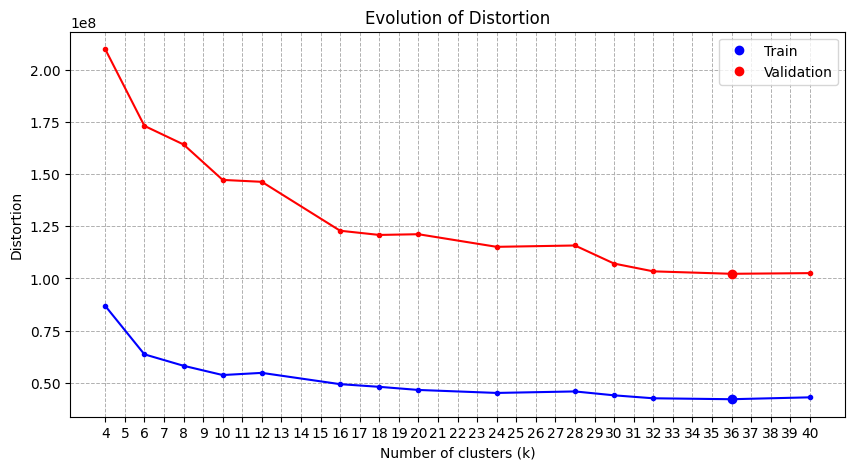

In [ ]:
# Plot the distortion in terms of "k".
plt.figure(figsize=(10, 5))

# Plot the lines:
plt.plot(k_values, distortion_SOM_train,      'b-')
plt.plot(k_values, distortion_SOM_validation, 'r-')
plt.xticks(range(4, 41))
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Evolution of Distortion')

# Plot the points.
for x, y in zip(k_values, distortion_SOM_train):
    if x == 36:
        plt.plot(x, y, 'bo', label='Train')
    else:
        plt.plot(x, y, 'b.')
for x, y in zip(k_values, distortion_SOM_validation):
    if x == 36:
        plt.plot(x, y, 'ro', label='Validation')
    else:
        plt.plot(x, y, 'r.')

plt.legend()

# Show plot and save it in high definition.
plt.savefig("distortion_k.png", dpi=300, bbox_inches='tight')
plt.show()


## 1.4. Maximum number of iterations determination


In [ ]:
# Define "max_iter" values to test.
max_iter_values = [50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 1000, 10000]

distortions_max_iter = []

# Function to compute distortion for a given "max_iter".
def compute_distortion(max_iter, data_train, data_test):
    model_SOM = Pipeline([
        ('scal', StandardScaler()),
        ('som', CustomSOM(m=6, n=6, dim=192, lr=2, max_iter=max_iter, random_state=42))
    ])
    data_train_normalized       = model_SOM[:-1].fit_transform(data_train)
    data_validation_normalized  = model_SOM[:-1].transform(data_test)
    SOM_train                   = model_SOM[-1].fit(data_train_normalized)
    distortion_SOM_train        = model_SOM.named_steps['som'].score(data_train_normalized)
    distortion_SOM_validation   = model_SOM.named_steps['som'].score(data_validation_normalized)
    return [distortion_SOM_train, distortion_SOM_validation]

# Run the computations in parallel.
distortions_max_iter = Parallel(n_jobs=1)(delayed(compute_distortion)(max_iter_values[i], numpy_data_jan_2021, numpy_data_apr_2024) for i in range(len(max_iter_values)))

# Generating individual lists for trains and validation.
distortion_SOM_train, distortion_SOM_validation = zip(*distortions_max_iter)
distortion_SOM_train        = list(distortion_SOM_train)
distortion_SOM_validation   = list(distortion_SOM_validation)

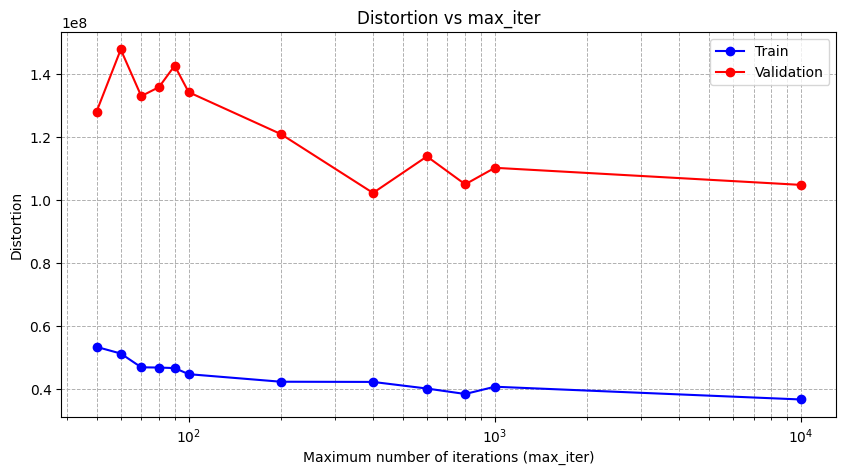

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the distortion in terms of "max_iter".
plt.figure(figsize=(10, 5))
plt.plot(max_iter_values, distortion_SOM_train,       marker='o', linestyle='-', color='b', label='Train')
plt.plot(max_iter_values, distortion_SOM_validation,  marker='o', linestyle='-', color='r', label='Validation')
plt.xlabel('Maximum number of iterations (max_iter)')
plt.ylabel('Distortion')
plt.title('Distortion vs max_iter')
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

# Show plot and save it in high definition.
plt.savefig("distortion_max_iter.png", dpi=300, bbox_inches='tight')
plt.show()

## 1.5. Learning rate determination

In [ ]:
# Define "lr" values to test.
lr_values = [0.001, 0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10]

distortions_lr = []

# Function to compute distortion for a given "lr".
def compute_distortion(lr, data_train, data_test):
    model_SOM = Pipeline([
        ('scal', StandardScaler()),
        ('som', CustomSOM(m=6, n=6, dim=192, lr=lr, max_iter=400, random_state=42))
    ])
    data_train_normalized       = model_SOM[:-1].fit_transform(data_train)
    data_validation_normalized  = model_SOM[:-1].transform(data_test)
    SOM_train                   = model_SOM[-1].fit(data_train_normalized)
    distortion_SOM_train        = model_SOM.named_steps['som'].score(data_train_normalized)
    distortion_SOM_validation   = model_SOM.named_steps['som'].score(data_validation_normalized)
    return [distortion_SOM_train, distortion_SOM_validation]

# Run the computations in parallel.
distortions_lr = Parallel(n_jobs=1)(delayed(compute_distortion)(lr_values[i], numpy_data_jan_2021, numpy_data_apr_2024) for i in range(len(lr_values)))

# Generating individual lists for trains and validation.
distortion_SOM_train, distortion_SOM_validation = zip(*distortions_lr)
distortion_SOM_train        = list(distortion_SOM_train)
distortion_SOM_validation   = list(distortion_SOM_validation)

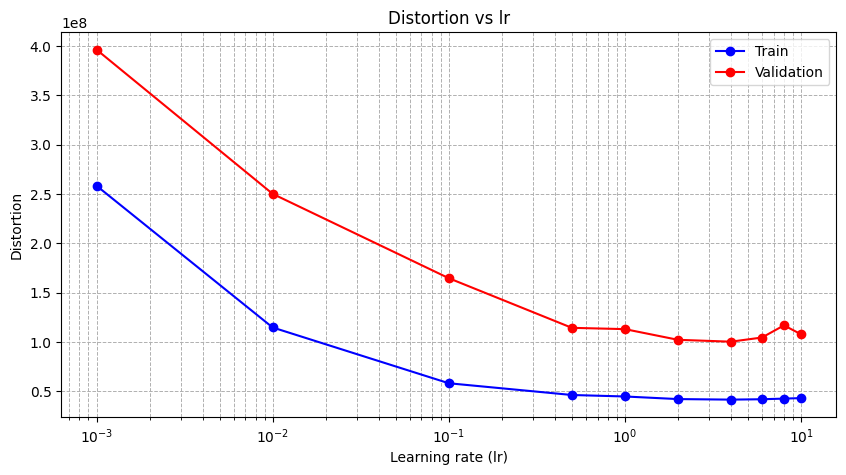

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the distortion in terms of "lr".
plt.figure(figsize=(10, 5))
plt.plot(lr_values, distortion_SOM_train , marker='o', linestyle='-', color='b', label='Train')
plt.plot(lr_values, distortion_SOM_validation, marker='o', linestyle='-', color='r', label='Validation')
plt.xlabel('Learning rate (lr)')
plt.ylabel('Distortion')
plt.title('Distortion vs lr')
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

# Show plot and save it in high definition.
plt.savefig("distortion_lr.png", dpi=300, bbox_inches='tight')
plt.show()

## 1.6. Fine tuning

In [9]:
# Function for plotting one day SOM clusters.
def plot_one_day(numpy_data, classes):
    x, y, n_variables = 171, 171, 192
    # Flattering original array.
    variables_flat = numpy_data
    variables_flat = variables_flat[0:29241]
    print(f"The one day input data has a shape of:             {variables_flat.shape}")
    # Reshape labels array.
    classes = classes.reshape(-1, 1)
    classes = classes[0:29241]
    print(f"The one day output labels has a shape of:          {classes.shape}")
    # Join of flattered original array and labels array.
    array_con_etiquetas = np.concatenate((variables_flat, classes), axis=-1)
    print(f"The one day joined array has a shape of:           {array_con_etiquetas.shape}")
    # Reshape of joined array.
    array_con_etiquetas = array_con_etiquetas.reshape(1, y, x, 193)
    array_con_etiquetas = array_con_etiquetas.reshape(1 * y , x, 193)
    print(f"The one day reshaped joined array has a shape of:  {array_con_etiquetas.shape}")
    # Plot code.
    import matplotlib.pyplot as plt
    data = array_con_etiquetas[:,:,192]
    plt.figure(figsize=(5, 4))
    plt.imshow(data, cmap='gnuplot2_r', interpolation='bilinear')
    plt.colorbar(label='ETo clusters')
    plt.title(f'ETo wheather heatmap with distortion:\n{distortion}')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()

The one day input data has a shape of:             (29241, 192)
The one day output labels has a shape of:          (29241, 1)
The one day joined array has a shape of:           (29241, 193)
The one day reshaped joined array has a shape of:  (171, 171, 193)


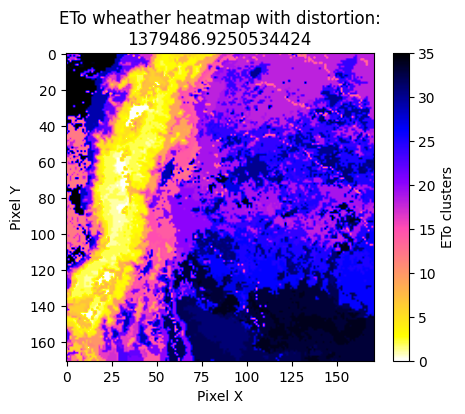

Number of clusters obtained:  36


In [10]:
# Filtering original 2 years data to one day data.
numpy_data_one_day  = numpy_data_apr_2024[0:29241]

# Train the one day data model with pipeline.
SOM_model_one_day = Pipeline([('scal', StandardScaler()),
                        ('som', CustomSOM(m=6,
                                          n=6,
                                          dim=192,
                                          lr=2,
                                          max_iter=390,
                                          random_state=42))
                       ])

SOM_train_inicial = SOM_model_one_day[:-1].fit_transform(numpy_data_one_day)
SOM_train         = SOM_model_one_day[-1].fit(SOM_train_inicial)
labels_SOM_train  = SOM_model_one_day.named_steps['som'].predict(SOM_train_inicial)
distortion        = SOM_model_one_day.named_steps['som'].score(SOM_train_inicial)

plot_one_day(numpy_data_one_day, labels_SOM_train)

print("Number of clusters obtained: ",len(np.unique(labels_SOM_train)))

## 1.7. SOM model training over all training dataset (years 2021 and 2022)

In [ ]:
# Data flattening.
# Input data is an array of three dimentions with the shape: ( d * y, x, 8 variables * 24 hours ), where:
# d: number of days,
# y: Pixel "Y",
# x: Pixel "X",
# 8 variables * 24 per 24 hours
print("Shape of the original data:  ",numpy_data_2021_2022.shape)
numpy_data_2021_2022 = numpy_data_2021_2022.reshape(-1, 192)
print("Shape of the flattened data: ",numpy_data_2021_2022.shape)

Shape of the original data:   (21345930, 192)
Shape of the flattened data:  (21345930, 192)


In [ ]:
# Normalization of the data.
scaler = StandardScaler()
numpy_data_2021_2022_normalized = scaler.fit_transform(numpy_data_2021_2022)
print('The two years normalized data has a shape of: ', numpy_data_2021_2022_normalized.shape)

# Save normalized data.
outpath = '/content/2021_2022_numpy_normalized.npy'
np.save( outpath, numpy_data_2021_2022_normalized, allow_pickle=False )

# Save the fitted normalization model.
# Download file and save it for future use in ETo weather model testing.
joblib.dump(scaler, '/content/scaler.pkl') #AUTHOR ONLY: joblib.dump(scaler, '/content/drive/MyDrive/ETo_weather/scaler.pkl')

The two years normalized data has a shape of:  (21345930, 192)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/ETo_weather/scaler.pkl']

In [ ]:
# Training the custom Scikit-learn SOM model.
som_model = CustomSOM(m=6, n=6, dim=192, lr=2, max_iter=390, random_state=42)
som_model.fit(numpy_data_2021_2022_normalized)

# Save the trained custom Scikit-learn SOM model.
# Download file and save it for future use in ETo weather model testing.
joblib.dump(som_model, '/content/ETo_weather_som_model.pkl') #AUTHOR ONLY: joblib.dump(som_model, '/content/drive/MyDrive/ETo_weather/ETo_weather_som_model.pkl')

['/content/drive/MyDrive/ETo_weather/ETo_weather_som_model_v2.pkl']

In [ ]:
# Prediction of the labels for the ETo weather clusters over training dataset.

# Function to predict SOM labels for a chunk of data.
def predict_chunk(som_model, data_chunk):
    return som_model.predict(data_chunk)

# Function to divide the data into chunks and process them in parallel.
def process_data_in_parallel(som_model, data, n_jobs=-1, chunk_size=None):
    n_samples = data.shape[0]
    if chunk_size is None:
        chunk_size = n_samples // 90
    data_chunks = [data[i:i + chunk_size] for i in range(0, n_samples, chunk_size)]

    # Parallel processing of each chunk.
    results = Parallel(n_jobs=n_jobs)(delayed(predict_chunk)(som_model, chunk) for chunk in data_chunks)

    # Join the predicted labels.
    return np.concatenate(results)

# Predictions and labels saving operation
# Download file and save it for future use in ETo climate input signal construction.
outpath_ETo_weather_labels = '/content/2021_2022_numpy_labels.npy' # AUTHOR ONLY: outpath_ETo_weather_labels = '/content/drive/MyDrive/ETo_weather/2021_2022_numpy_labels.npy'

if not os.path.exists(outpath_ETo_weather_labels):
    # Process data in parallel.
    som_model = joblib.load('/content/ETo_weather_som_model.pkl') # AUTHOR ONLY: som_model = joblib.load('/content/drive/MyDrive/ETo_weather/ETo_weather_som_model.pkl')
    labels_SOM_train = process_data_in_parallel(som_model, numpy_data_2021_2022_normalized)
    np.save(outpath_ETo_weather_labels, labels_SOM_train.astype(np.int16), allow_pickle=False)
    print(f'Labels array saved to: {outpath_ETo_weather_labels}\n')
    print('The two years ETo weather labels vector has a shape of: ', labels_SOM_train.shape)
else:
    print(f'File already exists at {outpath_ETo_weather_labels}')

File already exists at /content/drive/MyDrive/ETo_weather/2021_2022_numpy_labels.npy


# 2. Visualization of Evapotranspiration Variables and ETo Weather Clusters Obtained in the Train Dataset.

In [ ]:
# Concatenation of data and labels for plotting tasks.
labels_SOM_train = np.load('/content/drive/MyDrive/ETo_weather/2021_2022_numpy_labels.npy')
ETo_weather = np.concatenate((numpy_data_2021_2022, labels_SOM_train.reshape(-1,1)), axis=1)
print('The number of ETo weather clusters obtained is: ', len(np.unique(labels_SOM_train)))
print('The two years ETo weather data joined with the labels vector has a shape of: ', ETo_weather.shape)

# Unflattening operations for plotting tasks.
d, y, x, n_variables = 730, 171, 171, 192
ETo_weather_unflattened = ETo_weather.reshape(d * y, x, 193)
print(f"The two years ETo weather unflattened and joined data has a shape of: {ETo_weather_unflattened.shape}")

The number of ETo weather clusters obtained is:  36
The two years ETo weather data joined with the labels vector has a shape of:  (21345930, 193)
The two years ETo weather unflattened and joined data has a shape of: (124830, 171, 193)


In [ ]:
%matplotlib inline

!pip install ipywidgets>=7,<8

import ipywidgets         as widgets
import matplotlib.pyplot  as plt
from IPython.display      import display
from PIL                  import Image
from matplotlib.widgets   import Cursor
from google.colab         import output

/bin/bash: line 1: 8: No such file or directory


In [ ]:
# Enable custom widget manager for visualization
output.enable_custom_widget_manager()

# Dropdown menu for selecting a variable
dropdown = widgets.Dropdown(
    options=[('Net Radiation', 0),
             ('Ground Heat Flux', 1),
             ('Air Temperature at 2m', 2),
             ('Slope of Vapour Pressure Curve', 3),
             ('Psychrometric Constant', 4),
             ('Saturation Vapour Pressure', 5),
             ('Actual Vapour Pressure', 6),
             ('Wind Speed at 2m', 7),
             ('Evapotranspiration (Penman-Monteith)', 8)],
    value=0,  # Default value
    description='Variables:',
)

# Slider to select hour of the day
dropdown1 = widgets.IntSlider(min=0, max=23, step=1, description='Hour:')

# Slider to select the day
dropdown2 = widgets.IntSlider(min=0, max=729, step=1, description='Day:')

# Animation control
play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=2500,  # Interval in milliseconds
    description="Play",
    disabled=False
)

# Function for dropdown interaction
def dropdown_menu(variable=1, hour=1, day=1):
    # Set up figure for visualization
    fig, ax = plt.subplots(1, 1, figsize=(9, 3))
    fig.dpi = 90

    # Variables for indexing
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Variable indices
    y = list(range(24))  # Hours of the day
    z = list(range(730))  # Days

    # Determine the index of the selected variable, hour, and day
    variable_index = x.index(variable)
    hour_index = y.index(round(hour))
    day_index = z.index(round(day))

    # Extract data for the selected day
    day_data = ETo_weather_unflattened[171 * day_index : 171 * (day_index + 1)]

    # Variable names and labels
    variable_names = [
        'Net Radiation (MJ/(m²·hr))', 'Ground Heat Flux (MJ/(m²·hr))',
        'Air Temperature at 2m (°C)', 'Slope of Vapour Pressure Curve (kPa/°C)',
        'Psychrometric Constant (kPa/°C)', 'Saturation Vapour Pressure (kPa)',
        'Actual Vapour Pressure (kPa)', 'Wind Speed at 2m (m/s)',
        'Evapotranspiration (mm/day)'
    ]
    variable_units = [
        'MJ/(m²·hr)', 'MJ/(m²·hr)', '°C', 'kPa/°C',
        'kPa/°C', 'kPa', 'kPa', 'm/s', 'mm/day'
    ]

    # Extract data for the selected variable
    data = day_data[:, :, variable_index + (hour_index * 8)]

    # Compute evapotranspiration if the selected variable is Penman-Monteith
    if variable_index == 8:
        rad = day_data[:, :, 0 + (hour_index * 8)]
        flux = day_data[:, :, 1 + (hour_index * 8)]
        temp = day_data[:, :, 2 + (hour_index * 8)]
        slope_vapour = day_data[:, :, 3 + (hour_index * 8)]
        psych_const = day_data[:, :, 4 + (hour_index * 8)]
        saturation_p = day_data[:, :, 5 + (hour_index * 8)]
        actual_p = day_data[:, :, 6 + (hour_index * 8)]
        wind_speed = day_data[:, :, 7 + (hour_index * 8)]
        ETo = (
            (0.408 * slope_vapour * (rad - flux)) +
            psych_const * (37 / (temp + 273)) * (wind_speed) * (saturation_p - actual_p)
        ) / (slope_vapour + psych_const * (1 + 0.34 * wind_speed))
        data = ETo

    # Define color scale limits
    scale_min = [-1.0, -0.05, 2.00, 0.00, 0.03, 0, 0.0, 0.0, -0.15]
    scale_max = [1.2, 0.20, 31.00, 0.25, 0.08, 4, 3.2, 5.0, 0.69]

    # Plot the selected variable or evapotranspiration
    ax.clear()  # Clear the axes for updates
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)
    im = ax.imshow(
        data, cmap='gnuplot2',
        vmin=scale_min[variable_index], vmax=scale_max[variable_index],
        alpha=1, interpolation='bilinear'
    )
    ax.set_title(f'\n"{variable_names[variable_index]}"', color="steelblue")
    ax.set_xlabel('Geographic pixel in X axis')
    ax.set_ylabel('Geographic pixel in Y axis')

    # Add a color bar
    plt.colorbar(im, ax=ax, label=variable_units[variable_index])
    plt.show()

# Link the animation play button with the day slider
widgets.jslink((play, 'value'), (dropdown2, 'value'))

# Create interactive controls
widgets.interact(dropdown_menu, variable=dropdown, hour=dropdown1, day=dropdown2)

# Display play button for animation
widgets.HBox([play])

interactive(children=(Dropdown(description='Variables:', options=(('Net Radiation', 0), ('Ground Heat Flux', 1…

In [ ]:
output.enable_custom_widget_manager()
dropdown2 = widgets.IntSlider(min=0, max=729, step=1, description='DAY:')

play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

def Dropdown_Menu(dia=1):
    fig, (ax) = plt.subplots(1, 1, figsize=(9, 3))
    fig.dpi = 90

    y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    z = lista = list(range(0, 730))

    dias = z.index(round(dia))

    dia1 = ETo_weather_unflattened[0 + (171*(dias)) : 171 + (171*(dias))]

    data = dia1[:,:,round((192))]
    ETo_cluster = dia1[:,:,round((192))]
    ax.clear()
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.1)

    titulo_dinamico =  "ETo Weather Clusters for 2021 and 2022"
    im = ax.imshow(data, vmin=0, vmax=36, cmap='gnuplot2', alpha=1, interpolation='bilinear')
    ax.set_title(titulo_dinamico, color="steelblue")
    ax.set_xlabel('Geographic pixel in X axis')
    ax.set_ylabel('Geographic pixel in Y axis')
    plt.colorbar(im, ax=ax, label="Clusters")
    plt.show()

widgets.jslink((play, 'value'), (dropdown2, 'value'))

widgets.interact(Dropdown_Menu, dia=dropdown2)
widgets.HBox([play])


interactive(children=(IntSlider(value=0, description='DAY:', max=729), Output()), _dom_classes=('widget-intera…

# 3. Evaluation of Trained Dataset in Terms of Distortion

In [ ]:
# Load the normalized numpy data for 2021 and 2022.
numpy_data_2021_2022_normalized = np.load('/content/2021_2022_numpy_normalized.npy')

# Number of days in each month for two consecutive years (2021 and 2022).
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
                  31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Load the trained SOM model.
som_model = joblib.load('/content/ETo_weather_som_model.pkl') # AUTHOR ONLY: som_model = joblib.load('/content/drive/MyDrive/ETo_weather/ETo_weather_som_model.pkl')
# List to store distortion scores for each period.
ETo_weather_distortion = []

# Initialize day accumulators to track the range of days being processed.
day_acumulator_t0 = 0
day_acumulator_t1 = 0

# Loop through 24 periods (12 months in each of the two years).
for i in range(24):
    day_acumulator_t0 = day_acumulator_t1
    day_acumulator_t1 = day_acumulator_t1 + days_per_month[i]
    numpy_data_train_score = numpy_data_2021_2022_normalized[day_acumulator_t0 * 171 * 171 : day_acumulator_t1 * 171 * 171]
    distortion = som_model.score(numpy_data_train_score)
    ETo_weather_distortion.append(distortion)

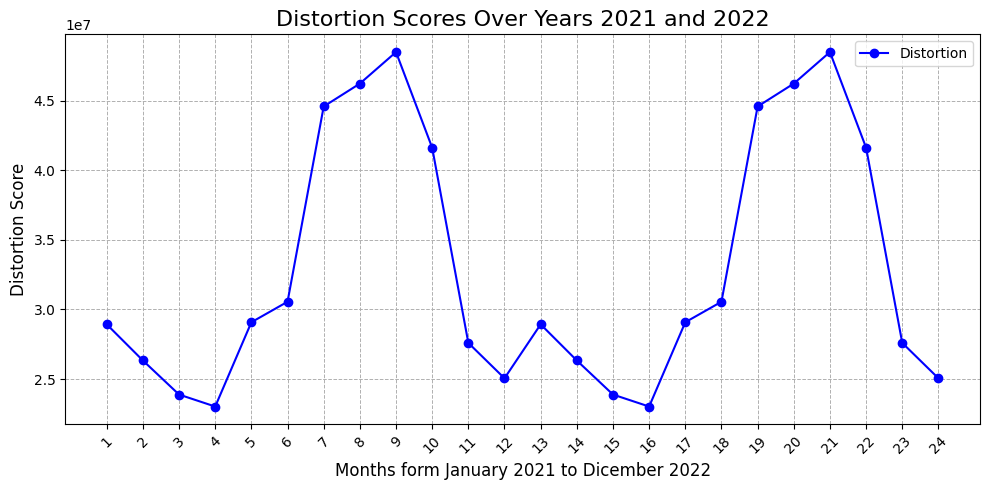

In [ ]:
from matplotlib.ticker import MultipleLocator

# Generate x-axis labels (indices of data points).
x = list(range(1,len(ETo_weather_distortion)+1))

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(x, ETo_weather_distortion, marker='o', linestyle='-', color='b', label='Distortion')
plt.title('Distortion Scores Over Years 2021 and 2022', fontsize=16)
plt.xlabel('Months form January 2021 to Dicember 2022', fontsize=12)
plt.ylabel('Distortion Score', fontsize=12)
plt.xticks(ticks=range(1, len(ETo_weather_distortion)+1), fontsize=10, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.show()